In [1]:
# Importera nödvändiga bibliotek
from sqlalchemy import create_engine, inspect
from prettytable import PrettyTable
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import scipy.stats as stats
from scipy.stats import t, ttest_ind

In [2]:
# Skapa en anslutning till AdventureWorks2022-databasen med SQLAlchemy 
engine = create_engine('mssql://GIRLIEQUINDAORA/AdventureWorks2022?trusted_connection=yes&driver=ODBC+Driver+17+for+SQL+Server')
connection = engine.connect()

print(type(connection))

<class 'sqlalchemy.engine.base.Connection'>


## SQL Query to Analyze Vendor Performance:

In [3]:
# Hämta POH.VendorID, PV.BusinessEntityID, V.Name(VendorName), V.ActiveFlag, V.PreferredVendorStatus, 
# P.ProductID, P.Name, POD.UnitPrice, POH.TaxAmt, POH.Freight, PV.AverageLeadTime & V.CreditRating 
vendor_performance_query = """
    SELECT 
    POH.VendorID,
    PV.BusinessEntityID,
    V.Name AS VendorName,
    V.ActiveFlag AS VendorActiveFlagStatus,
    V.PreferredVendorStatus,
    P.ProductID,
    P.Name AS ProductName,
    AVG(POD.UnitPrice) AS AvgUnitPrice,
    AVG(POH.TaxAmt) AS AvgTaxAmt,
    AVG(POH.Freight) AS AvgFreight,
    AVG(PV.AverageLeadTime) AS AvgDeliveryTime,
    V.CreditRating AS VendorPerformanceRating
FROM 
    Purchasing.PurchaseOrderHeader AS POH
INNER JOIN 
    Purchasing.PurchaseOrderDetail AS POD 
    ON POH.PurchaseOrderID = POD.PurchaseOrderID
INNER JOIN
    Purchasing.ProductVendor AS PV
    ON POD.ProductID = PV.ProductID
INNER JOIN
    Purchasing.Vendor AS V
    ON PV.BusinessEntityID = V.BusinessEntityID
INNER JOIN
    Production.Product AS P
    ON PV.ProductID = P.ProductID
GROUP BY
    POH.VendorID,
    PV.BusinessEntityID,
    V.Name,
    V.ActiveFlag,
    V.PreferredVendorStatus,
    P.ProductID,
    P.Name,
    V.CreditRating;
"""
# Samla eller lagra Vendor Performance SQL Query till Pandas DataFrame
vendor_performance_data = pd.read_sql_query(vendor_performance_query, engine)

# För att visa alla kolumner och rader
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Skriva ut eller visa kolumner som har i sql query
display(vendor_performance_data)

,VendorID,BusinessEntityID,VendorName,VendorActiveFlagStatus,PreferredVendorStatus,ProductID,ProductName,AvgUnitPrice,AvgTaxAmt,AvgFreight,AvgDeliveryTime,VendorPerformanceRating
0,1492,1492,Australia Bike Retailer,True,True,422,Thin-Jam Lock Nut 9,47.52,39.49,12.34,17,1
1,1492,1492,Australia Bike Retailer,True,True,423,Thin-Jam Lock Nut 10,45.42,39.49,12.34,17,1
2,1492,1492,Australia Bike Retailer,True,True,424,Thin-Jam Lock Nut 1,49.70,43.50,13.59,17,1
3,1492,1492,Australia Bike Retailer,True,True,425,Thin-Jam Lock Nut 2,45.42,43.50,13.59,17,1
4,1492,1492,Australia Bike Retailer,True,True,426,Thin-Jam Lock Nut 15,43.32,51.14,15.98,17,1
5,1492,1492,Australia Bike Retailer,True,True,427,Thin-Jam Lock Nut 16,47.60,45.40,14.19,17,1
6,1492,1492,Australia Bike Retailer,True,True,428,Thin-Jam Lock Nut 5,43.32,45.40,14.19,17,1
7,1492,1492,Australia Bike Retailer,True,True,429,Thin-Jam Lock Nut 6,41.22,54.42,17.01,17,1
8,1492,1492,Australia Bike Retailer,True,True,430,Thin-Jam Lock Nut 3,45.50,54.42,17.01,17,1
9,1492,1492,Australia Bike Retailer,True,True,431,Thin-Jam Lock Nut 4,41.22,54.42,17.01,17,1


## Visualize AvgUnitPrice by VendorPerformanceRating, ActiveFlag, and Preferred Status
#### UnitPrice = Vendor's selling price of a single product
#### CreditRatng = ( 1 = Superior, 2 = Excellent, 3 = Above average, 4 = Average, 5 = Below average)
#### ActiveFlag = (0 or False = Vendor no longer used,  1 or True = Vendor is actively used. Default: 1 or True)
#### PreferredVendorStatus = (0 or False = Do not use if another vendor is available. 1 or True = Preferred over other vendors supplying the same product. Default: 1 or True)

Reference: https://dataedo.com/download/AdventureWorks.pdf

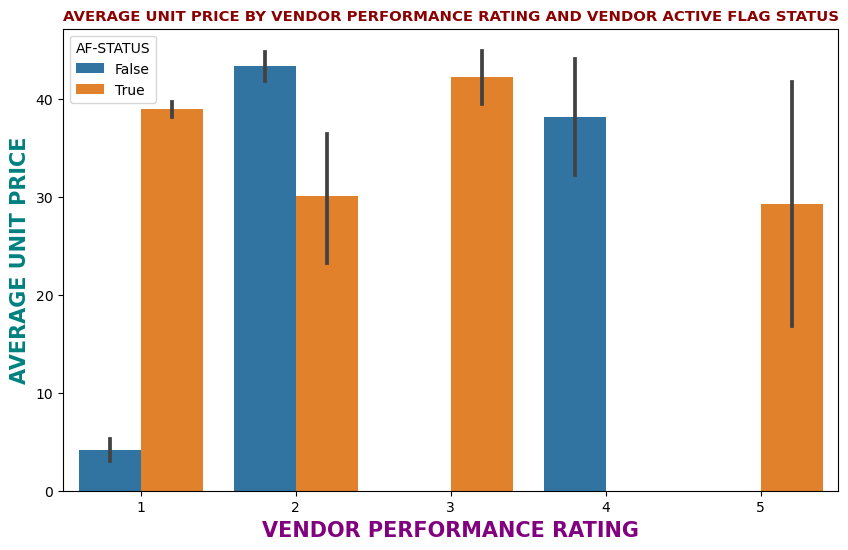

In [10]:
# Använd matplotlib och seaborn för att skapa ett stapeldiagram med flera kategorier baserat på 'VendorPerformanceRating', 
# 'AvgUnitPrice' och 'VendorActiveFlagStatus' från vendor_performance_data. 

# Skapa ett stapeldiagram med flera kategorier
plt.figure(figsize=(10, 6))
sns.barplot(x='VendorPerformanceRating', y='AvgUnitPrice', hue='VendorActiveFlagStatus', data=vendor_performance_data)
plt.xlabel('VENDOR PERFORMANCE RATING', size='15', color='purple', weight='1000')
plt.ylabel('AVERAGE UNIT PRICE', size='15', color='teal', weight='1000')
plt.title('AVERAGE UNIT PRICE BY VENDOR PERFORMANCE RATING AND VENDOR ACTIVE FLAG STATUS', size='10.7', color='darkred', weight='1000')
plt.legend(title='AF-STATUS')
plt.show()

### Calculate Confidence Intervals for Average Unit Price by Vendor Credit Rating & Vendor Active Flag Status

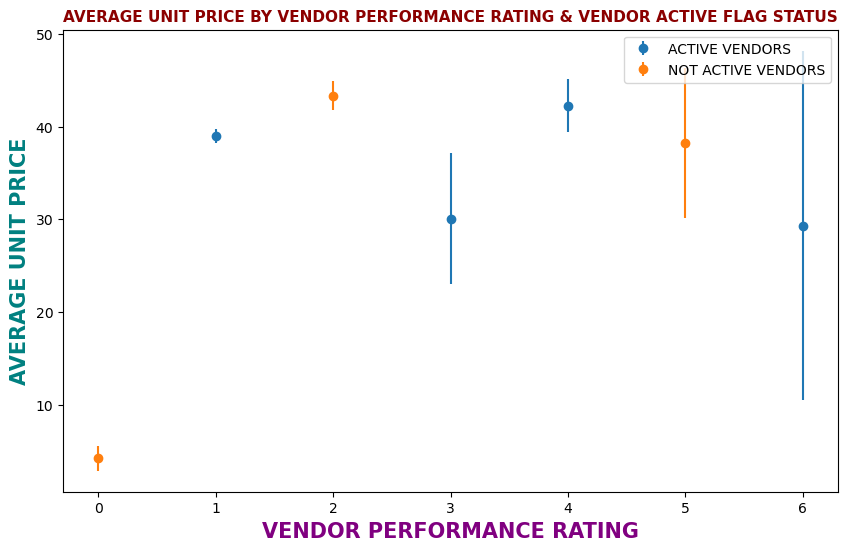

,VENDOR PERFORMANCE RATING,ACTIVE FLAG STATUS,CONFIDENCE INTERVAL
0,1,False,"(2.8622977042886646, 5.506202295711335)"
1,1,True,"(38.19796104413982, 39.714906380102605)"
2,2,False,"(41.77113255349158, 44.88886744650843)"
3,2,True,"(23.00943255907149, 37.118367440928495)"
4,3,True,"(39.39719499019892, 45.122821958953644)"
5,4,False,"(30.08676091410598, 46.308239085894016)"
6,5,True,"(10.452497013274776, 48.19000298672523)"


'T-statistic: 2.7951'

'P-value: 0.0053'

'Avvisa nollhypotesen (H0)! Det finns en signifikant skillnad i genomsnittliga enhetspriser mellan aktiva och inte aktiva leverantörer.'

In [6]:
# Beräkna konfidensintervallet för AvgUnitPrice baserat på VendorPerformanceRating och Vendor Active Flag Status
confidence_interval = []
for group, group_data in vendor_performance_data.groupby(['VendorPerformanceRating', 'VendorActiveFlagStatus']):
    data = group_data['AvgUnitPrice']
    interval = stats.t.interval(0.95, len(data) - 1, loc=data.mean(), scale=stats.sem(data))
    confidence_interval.append({'VENDOR PERFORMANCE RATING': group[0], 'ACTIVE FLAG STATUS': group[1], 'CONFIDENCE INTERVAL': interval})

# Visa konfidensintervallen i en DataFrame
confidence_interval_df = pd.DataFrame(confidence_interval)

# Separera data för aktiva leverantörer = TRUE och inte aktiva leverantörer = FALSE
active_vendors = vendor_performance_data[vendor_performance_data['VendorActiveFlagStatus'] == True]
not_active_vendors = vendor_performance_data[vendor_performance_data['VendorActiveFlagStatus'] == False]

# Hypotesprövning mellan aktiva leverantörer = TRUE och inte aktiva leverantörer = FALSE
t_stat, p_value = stats.ttest_ind(active_vendors['AvgUnitPrice'], not_active_vendors['AvgUnitPrice'])

# Visualisera konfidensintervall
plt.figure(figsize=(10, 6))
plt.errorbar(confidence_interval_df[confidence_interval_df['ACTIVE FLAG STATUS'] == True].index, 
             active_vendors.groupby('VendorPerformanceRating')['AvgUnitPrice'].mean(),
             yerr=[(ci[1] - ci[0]) / 2 for ci in confidence_interval_df[confidence_interval_df['ACTIVE FLAG STATUS'] == True]['CONFIDENCE INTERVAL']],
             label='ACTIVE VENDORS', fmt='o')
plt.errorbar(confidence_interval_df[confidence_interval_df['ACTIVE FLAG STATUS'] == False].index, 
             not_active_vendors.groupby('VendorPerformanceRating')['AvgUnitPrice'].mean(),
             yerr=[(ci[1] - ci[0]) / 2 for ci in confidence_interval_df[confidence_interval_df['ACTIVE FLAG STATUS'] == False]['CONFIDENCE INTERVAL']],
             label='NOT ACTIVE VENDORS', fmt='o')
plt.xlabel('VENDOR PERFORMANCE RATING', size='15', color='purple', weight='1000')
plt.ylabel('AVERAGE UNIT PRICE', size='15', color='teal', weight='1000')
plt.title('AVERAGE UNIT PRICE BY VENDOR PERFORMANCE RATING & VENDOR ACTIVE FLAG STATUS', size='11', color='darkred', weight='1000')
plt.legend()
plt.show()

# Visa / skriv ut resultaten
display(confidence_interval_df)
display(f"T-statistic: {t_stat:.4f}", f"P-value: {p_value:.4f}")

# Avgör om H0 ska avvisas eller inte och skriv ut resultatet
if p_value <= 0.05:
    display("Avvisa nollhypotesen (H0)! Det finns en signifikant skillnad i genomsnittliga enhetspriser mellan aktiva och inte aktiva leverantörer.")
else:
    display("Misslyckades att avvisa nollhypotesen (H0)! Det kanske inte finns en signifikant skillnad i genomsnittliga enhetspriser mellan aktiva och inte aktiva leverantörer.")


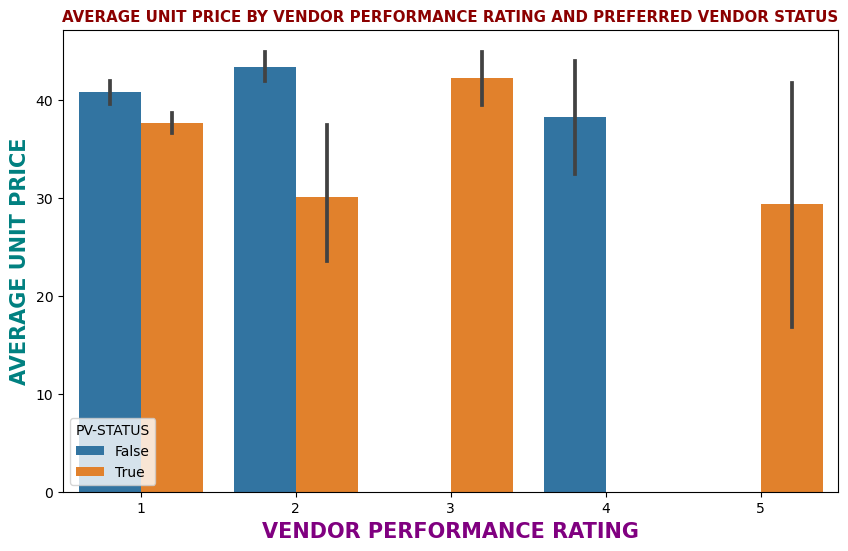

In [7]:
# Skapa ett stapeldiagram med flera kategorier genom att använda sns.barplot() från Seaborn-biblioteket. Det visualiserar 
# genomsnittliga enhetspriser för olika leverantörsprestanda betygsnivåer med hänsyn till deras för önskad status.

# Skapa ett stapeldiagram med flera kategorier
plt.figure(figsize=(10, 6))
sns.barplot(x='VendorPerformanceRating', y='AvgUnitPrice', hue='PreferredVendorStatus', data=vendor_performance_data)
plt.xlabel('VENDOR PERFORMANCE RATING', size='15', color='purple', weight='1000')
plt.ylabel('AVERAGE UNIT PRICE', size='15', color='teal', weight='1000')
plt.title('AVERAGE UNIT PRICE BY VENDOR PERFORMANCE RATING AND PREFERRED VENDOR STATUS', size='10.8', color='darkred', weight='1000')
plt.legend(title='PV-STATUS')
plt.show()

### Calculate Confidence Intervals for Average Unit Price by Vendor Credit Rating & Preferred Vendor Status

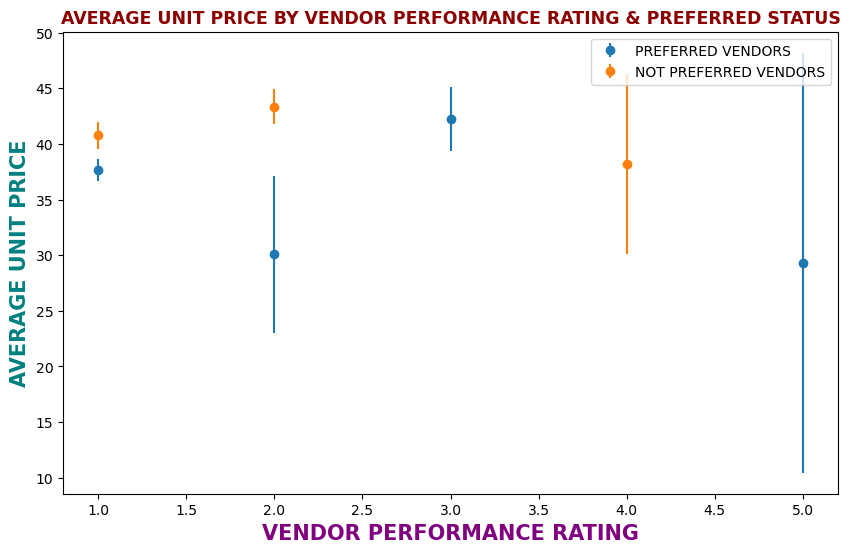

,VENDOR PERFORMANCE RATING,PREFERRED VENDOR STATUS,CONFIDENCE INTERVAL
0,1,False,"(39.57089769743624, 41.96426089287213)"
1,1,True,"(36.64002668983213, 38.63335591886352)"
2,2,False,"(41.77113255349158, 44.88886744650843)"
3,2,True,"(23.00943255907149, 37.118367440928495)"
4,3,True,"(39.39719499019892, 45.122821958953644)"
5,4,False,"(30.08676091410598, 46.308239085894016)"
6,5,True,"(10.452497013274776, 48.19000298672523)"


'T-statistic: -3.9173'

'P-value: 0.0001'

'Avvisa nollhypotesen (H0)! Det finns en signifikant skillnad i genomsnittliga enhetspriser mellan önskad och inte önskad leverantörer.'

In [13]:
# Beräkna konfidensintervallet för AvgUnitPrice baserat på VendorPerformanceRating och PreferredVendorStatus
confidence_interval_pref = []
for group, group_data in vendor_performance_data.groupby(['VendorPerformanceRating', 'PreferredVendorStatus']):
    data = group_data['AvgUnitPrice']
    interval = stats.t.interval(0.95, len(data) - 1, loc=data.mean(), scale=stats.sem(data))
    confidence_interval_pref.append({'VENDOR PERFORMANCE RATING': group[0], 'PREFERRED VENDOR STATUS': group[1], 'CONFIDENCE INTERVAL': interval})

# Visa konfidensintervallen i en DataFrame
confidence_interval_pref_df = pd.DataFrame(confidence_interval_pref)

# Separera data för 'Önskad' = TRUE ; 'Inte önskad' = FALSE
preferred_vendors = vendor_performance_data[vendor_performance_data['PreferredVendorStatus'] == True]
not_preferred_vendors = vendor_performance_data[vendor_performance_data['PreferredVendorStatus'] == False]

# Beräkna konfidensintervall för 'Önskad' = TRUE
ci_preferred = {}
for group, group_data in preferred_vendors.groupby('VendorPerformanceRating'):
    data = group_data['AvgUnitPrice']
    ci = stats.t.interval(0.95, len(data) - 1, loc=data.mean(), scale=stats.sem(data))
    ci_preferred[group] = ci

# Beräkna konfidensintervall för 'Inte önskad' = FALSE
ci_not_preferred = {}
for group, group_data in not_preferred_vendors.groupby('VendorPerformanceRating'):
    data = group_data['AvgUnitPrice']
    ci = stats.t.interval(0.95, len(data) - 1, loc=data.mean(), scale=stats.sem(data))
    ci_not_preferred[group] = ci

# Hypotesprövning mellan 'Önskad' = TRUE ; 'Inte önskad' = FALSE
t_stat, p_value = stats.ttest_ind(preferred_vendors['AvgUnitPrice'], not_preferred_vendors['AvgUnitPrice'])

# Visualisera konfidensintervall
plt.figure(figsize=(10, 6))
plt.errorbar(ci_preferred.keys(), preferred_vendors.groupby('VendorPerformanceRating')['AvgUnitPrice'].mean(),
             yerr=[(ci[1] - ci[0]) / 2 for ci in ci_preferred.values()], label='PREFERRED VENDORS', fmt='o')
plt.errorbar(ci_not_preferred.keys(), not_preferred_vendors.groupby('VendorPerformanceRating')['AvgUnitPrice'].mean(),
             yerr=[(ci[1] - ci[0]) / 2 for ci in ci_not_preferred.values()], label='NOT PREFERRED VENDORS', fmt='o')
plt.xlabel('VENDOR PERFORMANCE RATING', size='15', color='purple', weight='1000')
plt.ylabel('AVERAGE UNIT PRICE', size='15', color='teal', weight='1000')
plt.title('AVERAGE UNIT PRICE BY VENDOR PERFORMANCE RATING & PREFERRED STATUS', size='12.5', color='darkred', weight='1000')
plt.legend()
plt.show()

# Visa / skriv ut resultaten
display(confidence_interval_pref_df)
display(f"T-statistic: {t_stat:.4f}", f"P-value: {p_value:.4f}")

# Avgör om H0 ska avvisas eller inte och skriv ut resultatet
if p_value <= 0.05:
    display("Avvisa nollhypotesen (H0)! Det finns en signifikant skillnad i genomsnittliga enhetspriser mellan önskad och inte önskad leverantörer.")
else:
    display("Misslyckades att avvisa nollhypotesen (H0)! Det kanske inte finns en signifikant skillnad i genomsnittliga enhetspriser mellan önskad och inte önskad leverantörer.")


## Contact Informations of Preferred and Not Preferred Vendor Status

In [14]:
# Hämta adress och kontakt informationer om leverantörer med 'Önskad' = TRUE ; 'Inte önskad' = FALSE
vendor_contact_informations_query = """
    SELECT 
        vVA.*,  
        V.PreferredVendorStatus,
        vVC.ContactType,
        vVC.Title,
        vVC.FirstName,
        vVC.MiddleName,
        vVC.LastName,
        vVC.PhoneNumber,
        vVC.PhoneNumberType,
        vVC.EmailAddress,
        vVC.EmailPromotion
    FROM
        Purchasing.vVendorWithAddresses AS vVA
    INNER JOIN
        Purchasing.Vendor AS V
        ON vVA.BusinessEntityID = V.BusinessEntityID
    INNER JOIN
        Purchasing.vVendorWithContacts AS vVC
        ON V.BusinessEntityID = vVC.BusinessEntityID 
    WHERE 
        V.PreferredVendorStatus IN ('True', 'False')
    ORDER BY
        V.PreferredVendorStatus;
"""

# Kör SQL-frågor och spara till Pandas DataFrame
vendor_contact_informations_data = pd.read_sql_query(vendor_contact_informations_query, engine)

# Ange visningsalternativ för att visa alla rader och kolumner
pd.set_option('display.max_rows', None)  # Visa alla rader
pd.set_option('display.max_columns', None)  # Visa alla kolumner

# Skriv ut / Visa / Läs resultat / Utdata
display(vendor_contact_informations_data)

,BusinessEntityID,Name,AddressType,AddressLine1,AddressLine2,City,StateProvinceName,PostalCode,CountryRegionName,PreferredVendorStatus,ContactType,Title,FirstName,MiddleName,LastName,PhoneNumber,PhoneNumberType,EmailAddress,EmailPromotion
0,1656,Mountain Works,Main Office,8 Rogers Ave.,None,Everett,Washington,98201,United States,False,Sales Associate,Ms.,Cynthia,None,Randall,961-555-0100,Work,cynthia1@adventure-works.com,2
1,1686,Pro Sport Industries,Main Office,6360 Sand Pointe Lane,None,Coronado,California,92118,United States,False,Sales Manager,Mr.,Dave,None,Richards,582-555-0100,Work,dave1@adventure-works.com,0
2,1666,Leaf River Terrain,Main Office,1619 Mills Dr.,None,Albany,Oregon,97321,United States,False,Sales Agent,Ms.,Michelle,B.,Rector,459-555-0100,Cell,michelle1@adventure-works.com,1
3,1678,"Proseware, Inc.",Main Office,50 Big Canyon Road,None,Lebanon,Oregon,97355,United States,False,Sales Manager,Mr.,Eric,E.,Rhodes,113-555-0100,Work,eric8@adventure-works.com,2
4,1614,"Reliance Fitness, Inc.",Main Office,5514 Grant Street,None,Ballard,Washington,98107,United States,False,Sales Associate,Ms.,Carol,None,Philips,996-555-0100,Cell,carol3@adventure-works.com,0
5,1604,Bike Satellite Inc.,Main Office,2141 Delaware Ct.,None,Downey,Tennessee,37501,United States,False,Sales Agent,Mr.,Larry,None,Zhang,143-555-0100,Cell,larry0@adventure-works.com,0
6,1604,Bike Satellite Inc.,Main Office,2141 Delaware Ct.,None,Downey,Tennessee,37501,United States,False,Sales Manager,Ms.,Eunice,J.,Wolf,305-555-0100,Cell,eunice0@adventure-works.com,0
7,1604,Bike Satellite Inc.,Main Office,2141 Delaware Ct.,None,Downey,Tennessee,37501,United States,False,Sales Associate,Mr.,Jonathan,None,Perera,404-555-0100,Cell,jonathan1@adventure-works.com,1
8,1602,Beaumont Bikes,Main Office,2472 Alexander Place,None,West Covina,Idaho,83301,United States,False,Sales Associate,Mr.,Peng,None,Wu,306-555-0100,Work,peng1@adventure-works.com,0
9,1602,Beaumont Bikes,Main Office,2472 Alexander Place,None,West Covina,Idaho,83301,United States,False,Sales Agent,Mr.,John,None,Peoples,943-555-0100,Cell,john26@adventure-works.com,1
